# Connect G-Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
default_dir = "/content/drive/MyDrive/Data Science/Python/DS Project IV"
os.chdir(default_dir)

In [ ]:
!ls

 Churn_Modelling.csv  'DS Project 4 - Churn_Prediction.ipynb'


# Import Libraries

from catboost

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, GridSearchCV)

from sklearn.preprocessing import (
    scale, LabelEncoder, StandardScaler,
    MinMaxScaler, Normalizer, RobustScaler
)

from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_score, confusion_matrix, recall_score,
    roc_auc_score, roc_curve
)

# to display all columns and rows:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# The number of numbers that will be shown after the comma.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 1.&nbsp;Load Dataset

## 1.1 Description

Data Set Story:
- It consists of 10000 observations and 12 variables.
- Independent variables contain information about customers.
- Dependent variable refers to customer abandonment.


Features:
- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany / France / Spain)
- Gender: Gender (Female / Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: Bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Abandoned or not? (0 = No, 1 = Yes)

In [ ]:
df = pd.read_csv("Churn_Modelling.csv", index_col=0)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [ ]:
df_churn = df[df['Exited']==1]

In [ ]:
df_churn.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,2037.00,2037.00,2037.00,2037.00,2037.00,2037.00,2037.00,2037.00,2037.00,2037.00
mean,15690051.96,645.35,44.84,4.93,91108.54,1.48,0.70,0.36,101465.68,1.00
std,72692.62,100.32,9.76,2.94,58360.79,0.80,0.46,0.48,57912.42,0.00
min,15565706.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,1.00
25%,15627360.00,578.00,38.00,2.00,38340.02,1.00,0.00,0.00,51907.72,1.00
50%,15688963.00,646.00,45.00,5.00,109349.29,1.00,1.00,0.00,102460.84,1.00
75%,15753092.00,716.00,51.00,8.00,131433.33,2.00,1.00,1.00,152422.91,1.00
max,15815656.00,850.00,84.00,10.00,250898.09,4.00,1.00,1.00,199808.10,1.00


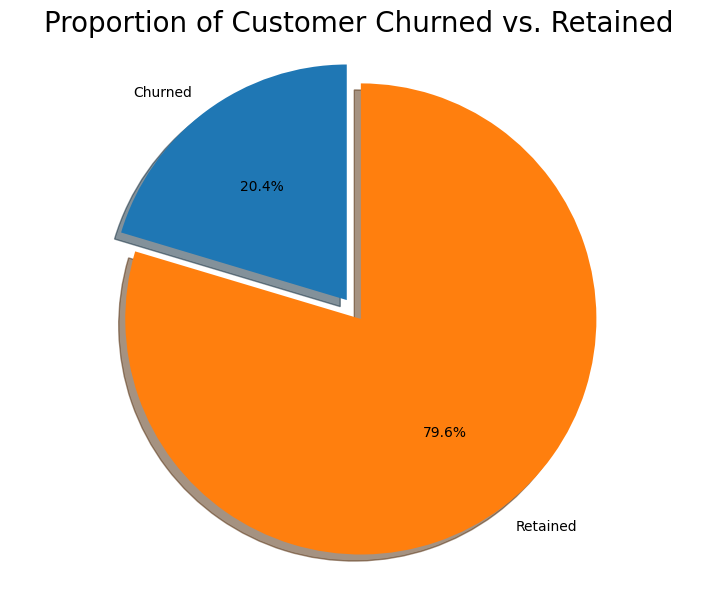

In [ ]:
labels = 'Churned', 'Retained'
sizes = [
    df.Exited[df['Exited']==1].count(),
    df.Exited[df['Exited']==0].count()
]
explode = (0, 0.1)

fig1, ax1 = plt.subplots(figsize=(9, 7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of Customer Churned vs. Retained", size = 20)
plt.show()

20.4% customer yang terindikasi Churned dan 79.6% Retained

# 2.&nbsp;EDA


## 2.1 Data Preparation

In [ ]:
dependent_variable_name = "Exited"

In [ ]:
#Fungsi untuk check unique value tiap kolom
def show_unique_count_variables(df):
    for index, value in df.nunique().items():
        print(str(index) + "\t\t:" + str(value))

#Fungsi untuk Check Missing Values hasilnya dataframe baru df_prep
def data_prepare():
    df_prep = df.copy()

    missing_value_len = df.isnull().any().sum()
    if missing_value_len == 0:
        print("No Missing Value")
    else:
        print("Investigate Missing Value, Missing Value : " + str(missing_value_len))
    print("\n")

    show_unique_count_variables(df=df_prep)

    df_prep['Tenure'] = df_prep.Tenure.astype(np.float)
    df_prep['NumOfProducts'] = df_prep.NumOfProducts.astype(np.float)
    return df_prep

### 2.2. Outliers Observe (LOF method and Supress)
#### 2.2.1. Outlier Editing

In [ ]:
#Fungsi untuk melihat visualisasi dari outliers
def show_outliers(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=2, ncols=5,
        gridspec_kw=dict(hspace=0.3), figsize=(12,9)
    )
    fig.tight_layout()
    for ax, col in zip(axes.flatten(), df_num_cols.columns):
        sns.boxplot(x=df_num_cols[col], color='green', ax=ax)
    fig.suptitle('Observing Outliers', color='r', fontsize=14)

#### 2.2.2. Visualization of outliers according to the LOF method

In [ ]:
def lof_observation(df):

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    df_outlier = df_num_cols.astype("float64")
    clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    clf.fit_predict(df_outlier)
    df_scores = clf.negative_outlier_factor_
    scores_df = pd.DataFrame(np.sort(df_scores))

    scores_df.plot(
        stacked=True, xlim=[0,20], color='r',
        title='Visualization of outliers according to the LOF method',
        style='.-'); # first 20 observe

    th_val = np.sort(df_scores)[2]
    outliers = df_scores > th_val
    df = df.drop(df_outlier[~outliers].index)
    df.shape
    return df

#### 2.2.3. Outlier suppression

In [ ]:
def clear_outliers(df):
    # For Age
    Q1 = df["Age"].quantile(0.25)
    Q3 = df["Age"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed below lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["Age"][(df["Age"] > upper)]
    df["Age"][df_outlier.index] = upper

    # For Credit Score
    Q1 = df["CreditScore"].quantile(0.25)
    Q3 = df["CreditScore"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed above lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["CreditScore"][(df["CreditScore"] < lower)]
    df["CreditScore"][df_outlier.index] = lower
    return df

#### 2.2.4. Outiler Process

In [ ]:
def outlier_process(df):
    df_outlier = lof_observation(df=df)
    df_outlier = clear_outliers(df=df_outlier)
    return df_outlier

### 2.3. Data Analysis
#### 2.3.1. Dependent variable distribution

In [ ]:
def show_dependent_variable(df):
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    sns.countplot(x='Geography', hue='Exited', data=df, ax=axarr[0][0])
    sns.countplot(x='Gender', hue='Exited', data=df, ax=axarr[0][1])
    sns.countplot(x='HasCrCard', hue='Exited', data=df, ax=axarr[0][2])
    sns.countplot(x='IsActiveMember', hue='Exited', data=df, ax=axarr[1][0])
    sns.countplot(x='NumOfProducts', hue='Exited', data=df, ax=axarr[1][1])
    sns.countplot(x='Tenure', hue='Exited', data=df, ax=axarr[1][2])
    zero, one = df[dependent_variable_name].value_counts()
    print("Dependent variable distribution;")
    print(dependent_variable_name + " 0 count:", zero)
    print(dependent_variable_name + " 1 count:", one)

#### 2.3.2. Numeric columns distribution observation

In [ ]:
def show_numeric_columns_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]
    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle('Structures of numeric variables', color='r', fontsize=18)
    plt.show()

#### 2.3.3. Status of other variables according to dependent variable

In [ ]:
def show_dependent_variable_cross_others_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_dependent_var = df[df[dependent_variable_name]==1]
    df_num_cols = df_dependent_var.select_dtypes(include=numerics)
    columns = df_num_cols.columns[:len(df_num_cols.columns)]

    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle(dependent_variable_name + ' Status of other variables according to 1 dependent variable', color='r', fontsize=18)
    plt.show()

#### 2.3.4. Categorical variables are observed according to the dependent variable

In [ ]:
def show_dependent_variable_cross_categorical_distributions(df, categorical_columns):
    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=int(len(categorical_columns)/2 ),
        ncols=2,
        figsize=(7,9)
    )
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), categorical_columns):
        sns.countplot(x=df[col], hue=dependent_variable_name, data=df, ax=ax)
    fig.suptitle('Categorical variables are monitored according to the dependent variable', color='r', fontsize=1)


#### 2.3.5. The main method that started all data analysis

In [ ]:
def show_data_analysis(df):
    show_dependent_variable(df)
    show_numeric_columns_distributions(df)
    show_dependent_variable_cross_others_distributions(df)
    show_dependent_variable_cross_categorical_distributions(
        df=df_outlier,
        categorical_columns=["Gender", "Geography", "HasCrCard", "IsActiveMember"]
    )

## 3.&nbsp;Feature Engineering

In [ ]:
def credit_score_table(row):
    credit_score = row.CreditScore
    if credit_score < 300:
      return "Deep"
    elif 300 <= credit_score < 500:
        return "Very_Poor"
    elif 500 <= credit_score < 601:
        return "Poor"
    elif 601 <= credit_score < 661:
        return "Fair"
    elif 661 <= credit_score < 781:
        return "Good"
    elif 781 <= credit_score < 851:
        return "Excellent"
    else:
        return "Top"

"Deep" : credit_score < 300
"Very_Poor" : 300 <= credit_score < 500
"Poor" : 500 <= credit_score < 601
"Fair" : 601 <= credit_score < 661
"Good" : 661 <= credit_score < 781
"Excellent" : 781 <= credit_score < 851
"Top" : credit_score => 851

### 3.2. Product utilization RATE by YEAR

In [ ]:
def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure

    if number_of_products == 0:
        return 0

    if tenure == 0:
        return number_of_products

    rate = number_of_products/tenure
    return rate

### 3.3. Product utilization rate by estimated SALARY

In [ ]:
def product_utilization_rate_by_estimated_salary(row):
    number_of_products = row.number_of_products
    estimated_salary = row.EstimatedSalary

    if number_of_products == 0:
        return 0

    rate = number_of_products / estimated_salary
    return rate

### 3.4. According to countries monthly average salaries

reference: [Link](https://en.wikipedia.org/wiki/List_of_European_countries_by_average_wage)

In [ ]:
def countries_monthly_average_salaries(row):
    fr = 3696
    de = 4740
    sp = 2257
    salary = row.EstimatedSalary / 12
    country = row.Geography # Germany, France and Spain

    if country == 'Germany':
        return salary / de
    elif country == "France":
        return salary / fr
    elif country == "Spain":
        return salary / sp

Menghitung rasio atau perbandingan antara gaji bulanan (EstimatedSalary) dari seorang individu dalam dataset dengan rata-rata gaji bulanan di negara tempat individu tersebut tinggal

### 3.5. The main method that started all Feature Engineering

In [ ]:
def feature_engineering(df, is_show_graph = False):
    df_fe = df.copy()

    balance_salary_rate = 'balance_salary_rate'
    df_fe[balance_salary_rate] = df_fe.Balance / df_fe.EstimatedSalary

    df_fe = df_fe.assign(
        product_utilization_rate_by_year=df_fe.apply(
            lambda x: product_utilization_rate_by_year(x),
            axis=1
            )
        )

    tenure_rate_by_age = 'tenure_rate_by_age'
    df_fe[tenure_rate_by_age] = df_fe.Tenure/(df_fe.Age-17)

    credit_score_rate_by_age = 'credit_score_rate_by_age'
    df_fe[credit_score_rate_by_age] = df_fe.CreditScore/(df_fe.Age-17)

    product_utilization_rate_by_salary = 'product_utilization_rate_by_salary'

    credit_score_rate_by_salary = 'credit_score_rate_by_salary'
    df_fe[credit_score_rate_by_salary] = df_fe.CreditScore/(df_fe.EstimatedSalary)

    if is_show_graph:
        fig, axes = plt.subplots(
            nrows=2, ncols=2, figsize=(20,12))
        fig.tight_layout()
        sns.boxplot(
            y=balance_salary_rate,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][0]
        )
        sns.boxplot(
            y=product_utilization_rate_by_year,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][1]
        )
        plt.ylim(-1, 5)

    df_fe = df_fe.assign(credit_score_table=df_fe.apply(lambda x: credit_score_table(x), axis=1))
    df_fe = df_fe.assign(countries_monthly_average_salaries = df_fe.apply(lambda x: countries_monthly_average_salaries(x), axis=1))
    return df_fe

# 4.&nbsp;Data Encoding

In [ ]:
def data_encoding(df):
    df_model = df.copy()
    # >>>> Categorical columns <<<<<
    non_encoding_columns = [
        "Geography", "HasCrCard","IsActiveMember",
        "Gender", "NumOfProducts", "Tenure", "credit_score_table"]

    df_non_encoding = df_model[non_encoding_columns]
    df_model = df_model.drop(non_encoding_columns, axis=1)
    df_encoding = df_non_encoding.copy()

    encoder = LabelEncoder()
    df_encoding["gender_category"] = encoder.fit_transform(df_non_encoding.Gender)
    df_encoding["country_category"] = encoder.fit_transform(df_non_encoding.Geography)
    df_encoding["credit_score_category"] = encoder.fit_transform(df_non_encoding.credit_score_table)

    df_encoding.reset_index(drop=True, inplace=True)
    df_model.reset_index(drop=True, inplace=True)
    df_model = pd.concat([df_model, df_encoding], axis=1)

    df_model = df_model.drop(
        ["Geography", "Gender" , "CustomerId", "Surname",
         "credit_score_table", "CreditScore", "EstimatedSalary"],
        axis=1)

    df_model = df_model.reset_index()
    df_model = df_model.drop('index', axis=1)

    df_model.loc[df_model.HasCrCard==0, 'credit_card_situation'] = -1
    df_model.loc[df_model.IsActiveMember==0, 'is_active_member'] = -1
    return df_model

# 5.&nbsp;Model Preparation

In [ ]:
def model_prepare(df_model):

    X = df_model.loc[:, df_model.columns != dependent_variable_name]
    y = df_model[dependent_variable_name]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test

### 5.1 Part of Data Train

In [ ]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('XGBoost', XGBClassifier()))
    models.append(('LightGBM', LGBMClassifier()))

    res_cols = [
        'model', 'accuracy_score', 'scale_method',
        "0_precision", "0_recall", "1_precision", "1_recall"
    ]
    df_result = pd.DataFrame(columns=res_cols)

    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']
        res_vals = [name, score, "NA", zero_report['precision'], zero_report['recall'], one_report['precision'], one_report['recall']]
        df_result.at[index, res_cols] = res_vals
        index += 1
    return df_result.sort_values("accuracy_score", ascending=False)

# 6.&nbsp;HELPER Functions

In [ ]:
# Function to give best model score and parameters

def best_model(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)

def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method);
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2);
    return (auc_score, fpr_df, tpr_df)

from matplotlib import rc, rcParams
def plot_confusion_matrix(
    cm, classes,
    normalize=False,
    title='Confusion Matrix',
    cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.rcParams.update({'font.size': 16})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 7.&nbsp;Data Cleaning

In [ ]:
df_prep = data_prepare()

No Missing Value


CustomerId		:10000
Surname		:2932
CreditScore		:460
Geography		:3
Gender		:2
Age		:70
Tenure		:11
Balance		:6382
NumOfProducts		:4
HasCrCard		:2
IsActiveMember		:2
EstimatedSalary		:9999
Exited		:2


In [ ]:
df_prep['Exited'].value_counts(normalize=True)

0   0.80
1   0.20
Name: Exited, dtype: float64

Dataset mengalami imbalance dataset

When age and credit score is printed below lower score:  14.0 and upper score:  62.0
When age and credit score is printed above lower score:  383.0 and upper score:  919.0


<ipython-input-23-88e44ad234b5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Age"][df_outlier.index] = upper
<ipython-input-23-88e44ad234b5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CreditScore"][df_outlier.index] = lower


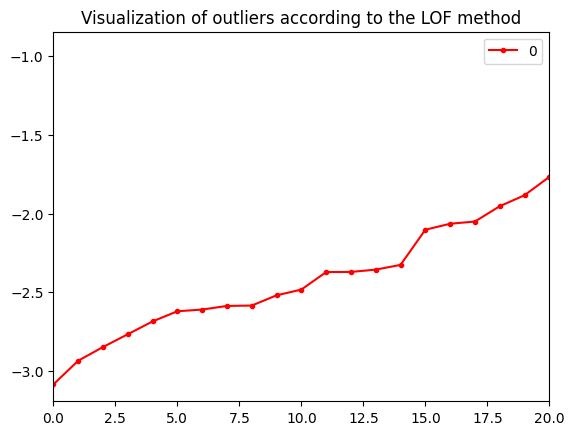

In [ ]:
df_outlier = outlier_process(df=df_prep)

Dependent variable distribution;
Exited 0 count: 7963
Exited 1 count: 2037


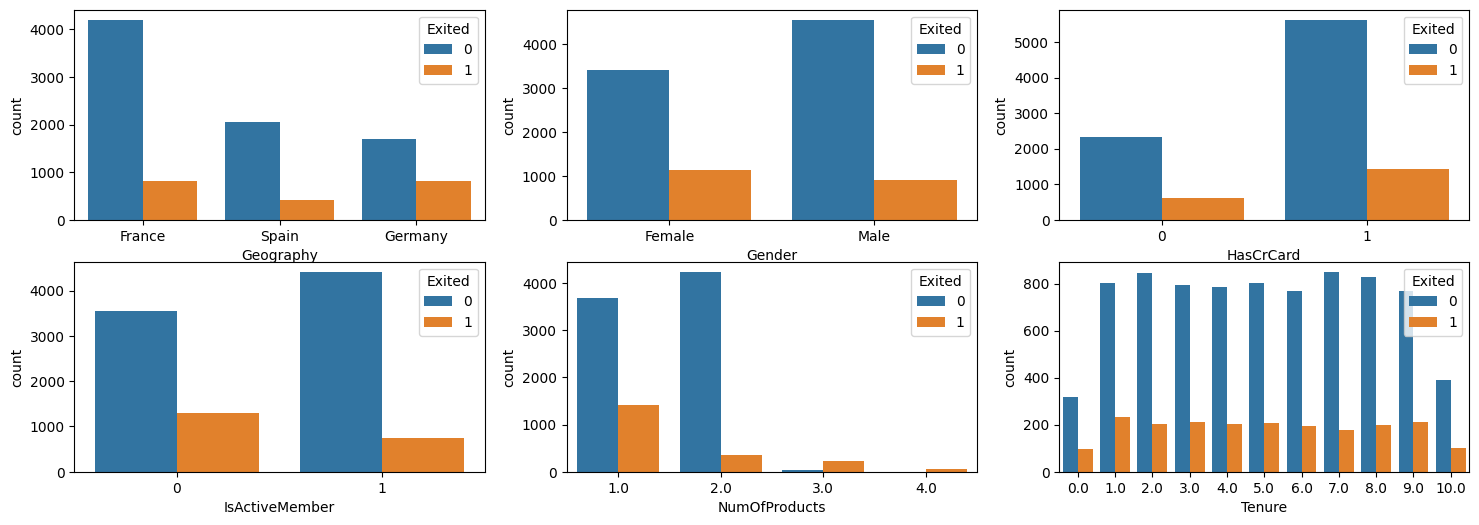

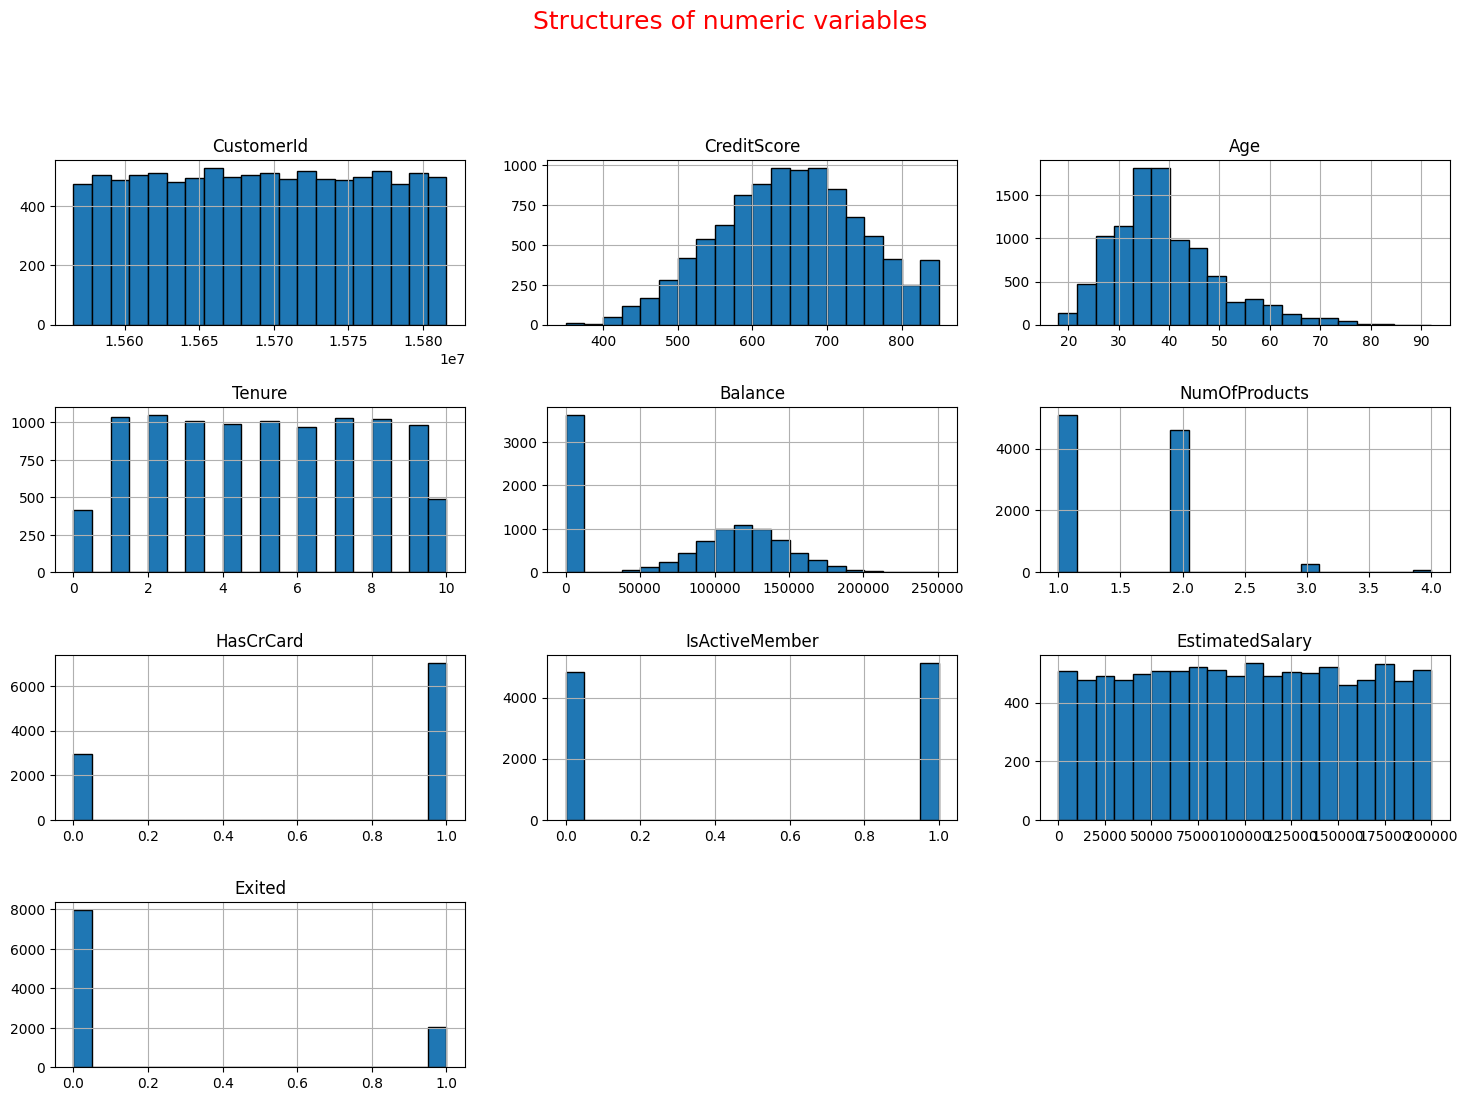

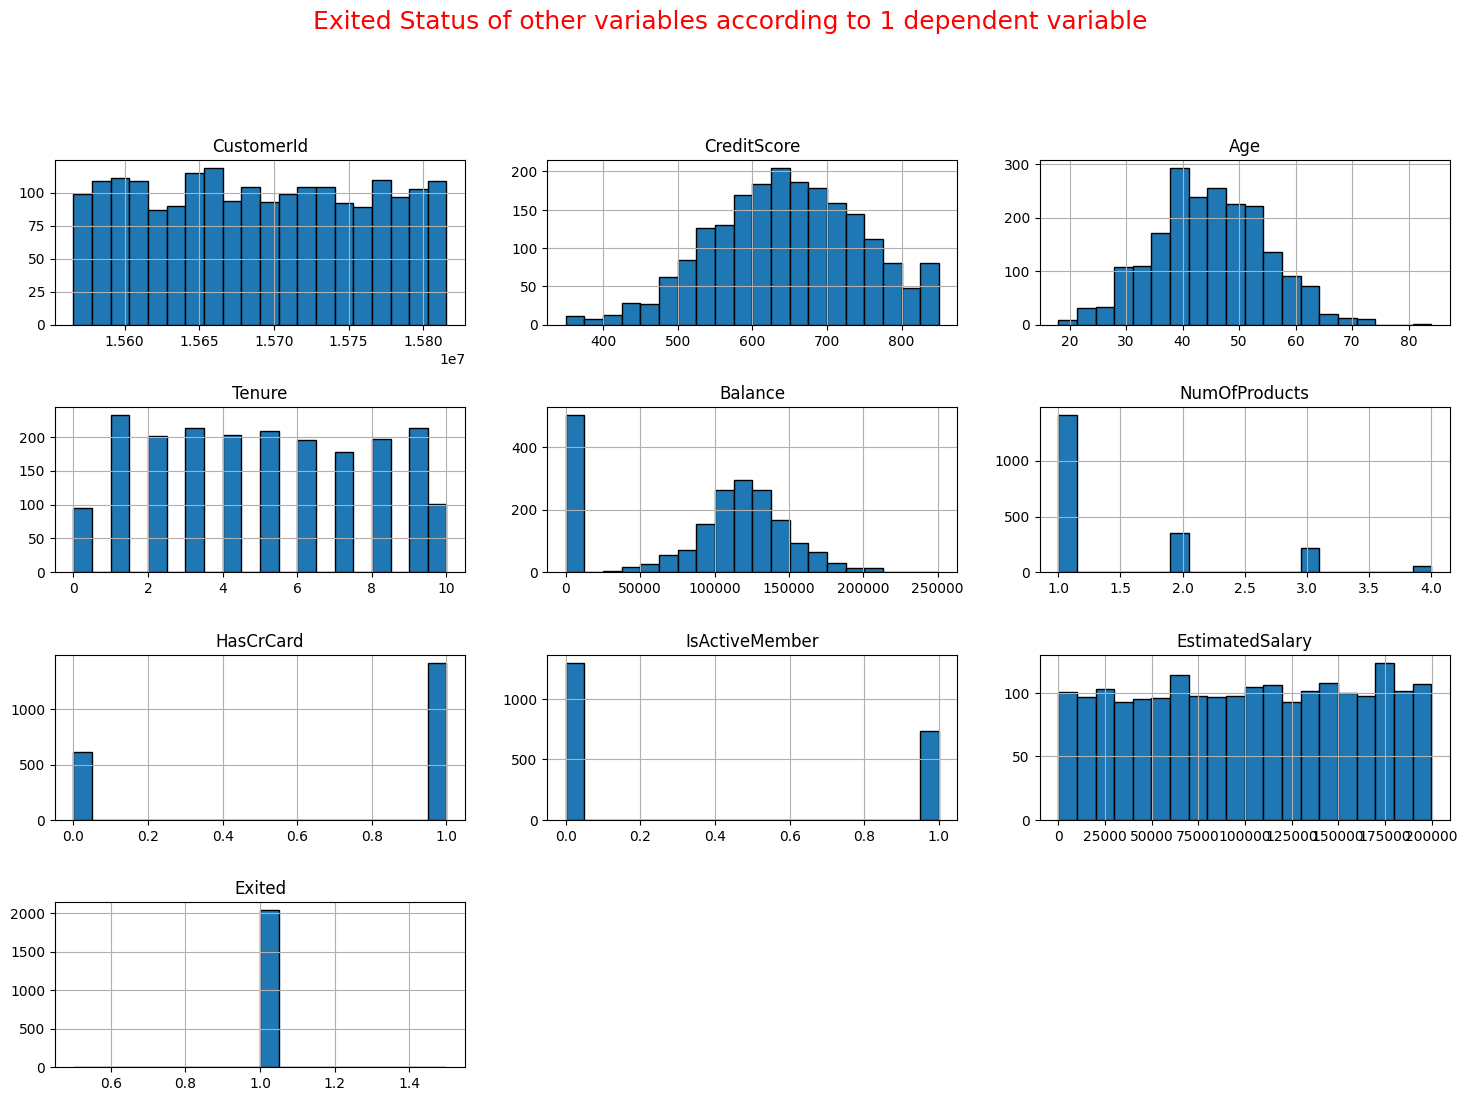

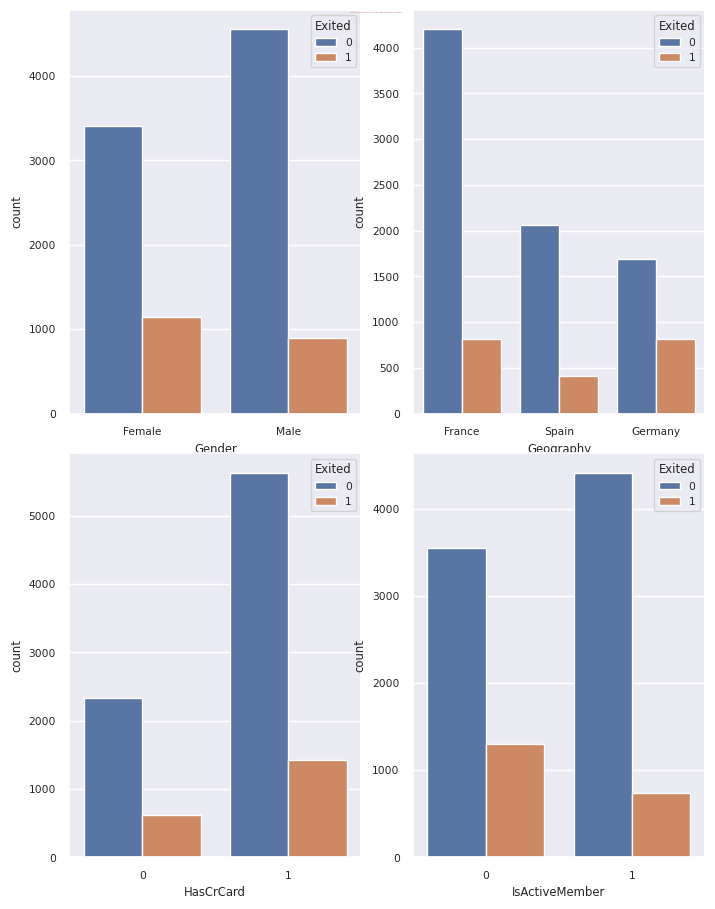

In [ ]:
show_data_analysis(df_prep)

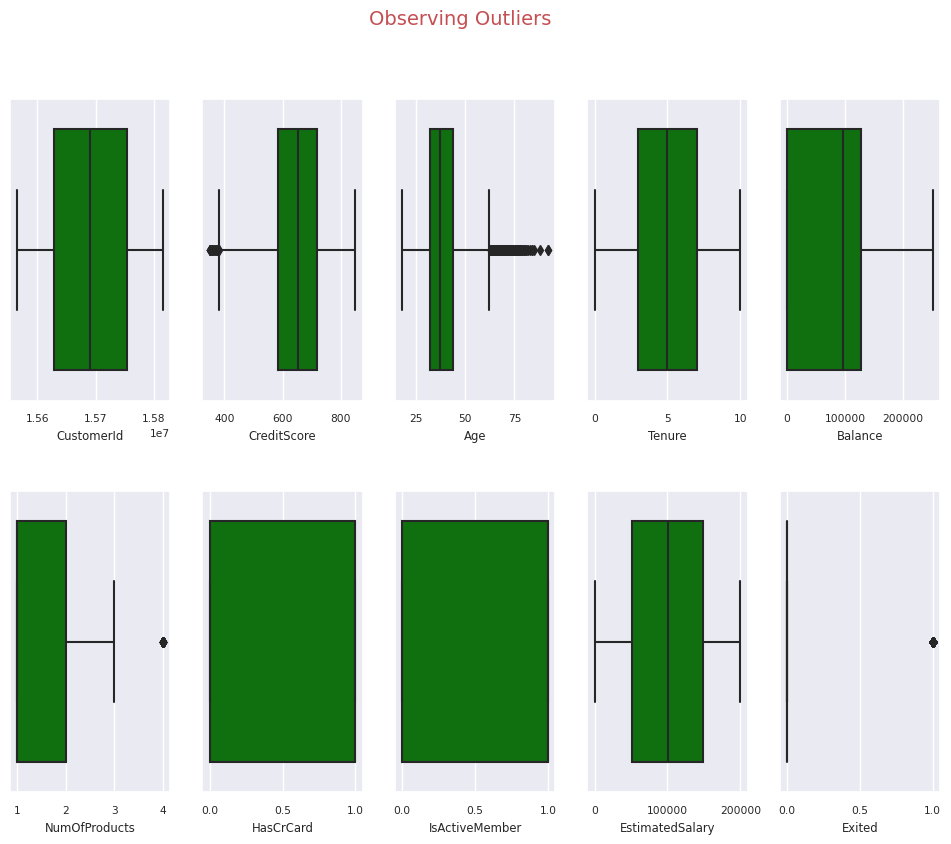

In [ ]:
show_outliers(df=df_prep)

Visualisasi bloxplot sebelum dilakukan penanggulangan outliers
- terdapat outliers pada CreditScore dan Age

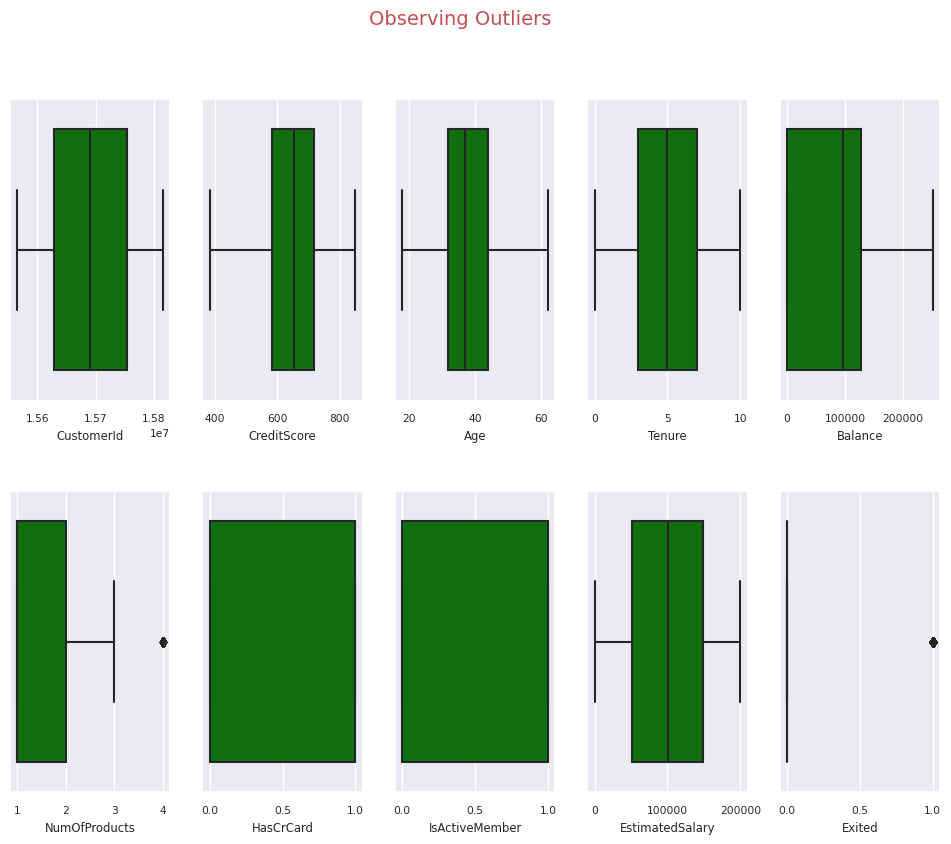

In [ ]:
show_outliers(df=df_outlier)

Visualisasi bloxplot sesudah dilakukan penanggulangan outliers

Let's see after feature engineering:

In [ ]:
df_fe = feature_engineering(df = df_outlier)
df_fe.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,credit_score_table,countries_monthly_average_salaries
RowNumber,,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1.00,1,1,101348.88,1,0.00,0.50,0.08,24.76,0.01,Fair,2.29
2,15647311,Hill,608,Spain,Female,41,1.00,83807.86,1.00,0,1,112542.58,0,0.74,1.00,0.04,25.33,0.01,Fair,4.16
3,15619304,Onio,502,France,Female,42,8.00,159660.80,3.00,1,0,113931.57,1,1.40,0.38,0.32,20.08,0.00,Poor,2.57
4,15701354,Boni,699,France,Female,39,1.00,0.00,2.00,0,0,93826.63,0,0.00,2.00,0.05,31.77,0.01,Good,2.12
5,15737888,Mitchell,850,Spain,Female,43,2.00,125510.82,1.00,1,1,79084.10,0,1.59,0.50,0.08,32.69,0.01,Excellent,2.92
6,15574012,Chu,645,Spain,Male,44,8.00,113755.78,2.00,1,0,149756.71,1,0.76,0.25,0.30,23.89,0.00,Fair,5.53
7,15592531,Bartlett,822,France,Male,50,7.00,0.00,2.00,1,1,10062.80,0,0.00,0.29,0.21,24.91,0.08,Excellent,0.23
8,15656148,Obinna,383,Germany,Female,29,4.00,115046.74,4.00,1,0,119346.88,1,0.96,1.00,0.33,31.92,0.00,Very_Poor,2.10
9,15792365,He,501,France,Male,44,4.00,142051.07,2.00,0,1,74940.50,0,1.90,0.50,0.15,18.56,0.01,Poor,1.69


**balance_salary_rate:**

- Kegunaan: Rasio antara saldo dalam rekening dan perkiraan gaji. Fitur ini mencerminkan seimbangnya antara jumlah saldo dan perkiraan gaji nasabah.
- Contoh:
Pada contoh hasil: Baris 1 memiliki rasio 0.00 (saldo 0 dibagi perkiraan gaji), sedangkan baris 2 memiliki rasio 0.74 (saldo relatif lebih rendah dibandingkan perkiraan gaji).
- Cara membaca: Rasio yang lebih tinggi menunjukkan saldo yang lebih besar dibandingkan dengan gaji, sementara rasio yang lebih rendah menunjukkan kebalikannya.

**product_utilization_rate_by_year:**

- Kegunaan: Rasio pemanfaatan produk per tahun. Menunjukkan seberapa sering produk bank digunakan oleh pelanggan dalam satu tahun.
- Contoh:
Pada contoh hasil: Baris 1 memiliki rasio 0.50, artinya ada 1 produk digunakan selama 2 tahun (0.5 produk per tahun), sedangkan baris 2 memiliki rasio 1.00, artinya 1 produk digunakan selama 1 tahun (1 produk per tahun).
- Cara membaca: Rasio yang lebih tinggi menunjukkan penggunaan produk yang lebih sering dalam satu tahun.

**tenure_rate_by_age:**

- Kegunaan: Rasio lamanya hubungan dengan bank dibandingkan dengan usia nasabah.
- Contoh:
Pada contoh hasil: Baris 1 memiliki rasio 0.08, artinya memiliki hubungan dengan bank selama 2 tahun dibandingkan dengan usia 42 tahun, sedangkan baris 3 memiliki rasio 0.32, artinya memiliki hubungan dengan bank selama 8 tahun dibandingkan dengan usia 42 tahun.
- Cara membaca: Rasio yang lebih tinggi menunjukkan hubungan yang lebih kuat atau lebih lama dengan bank relatif terhadap usia nasabah.

**credit_score_rate_by_age:**

- Kegunaan: Rasio antara skor kredit dengan perbedaan usia nasabah dan 17.
- Contoh:
Pada contoh hasil: Baris 1 memiliki rasio 24.76, artinya skor kredit 619 dibagi dengan (42-17) usia nasabah, sedangkan baris 2 memiliki rasio 25.33.
- Cara membaca: Rasio yang lebih tinggi menunjukkan skor kredit yang lebih baik relatif terhadap usia nasabah.

**credit_score_rate_by_salary:**

- Kegunaan: Rasio antara skor kredit dengan perkiraan gaji.
- Contoh:
Pada contoh hasil: Baris 1 memiliki rasio 0.01, artinya skor kredit 619 dibagi dengan perkiraan gaji 101348.88, sedangkan baris 2 memiliki rasio 0.01.
- Cara membaca: Rasio yang lebih tinggi menunjukkan seimbangnya skor kredit dengan perkiraan gaji.

**credit_score_table:**

Kegunaan: Kategori atau label yang mungkin dihasilkan dari transformasi atau kategorisasi nilai-nilai skor kredit.
Contoh:
Pada contoh hasil: Baris 1 memiliki kategori "Fair", sedangkan baris 3 memiliki kategori "Poor".
Cara membaca: Kategori ini mungkin mencerminkan kualitas atau kelas dari skor kredit.

**countries_monthly_average_salaries:**

- Kegunaan: Fungsi ini menghitung rasio gaji bulanan individu dengan rata-rata gaji bulanan di negara tempat individu tersebut tinggal. Ini memungkinkan perbandingan seberapa tinggi atau rendah gaji individu relatif terhadap rata-rata gaji bulanan di negara tersebut.

- Contoh:
Pada contoh hasil: Baris 1 memiliki rasio 2.29, yang berarti gaji bulanan individu adalah sekitar 2.29 kali lebih rendah dari rata-rata gaji bulanan di negara asalnya (dibandingkan dengan rata-rata gaji di Jerman), sedangkan pada baris 2 memiliki rasio 4.16, yang menunjukkan gaji bulanan individu sekitar 4.16 kali lebih tinggi dari rata-rata gaji bulanan di negara asalnya.

- Cara Membaca: Rasio yang lebih tinggi menunjukkan bahwa gaji bulanan individu lebih tinggi secara relatif terhadap rata-rata gaji bulanan di negara tempat individu tersebut tinggal, sementara rasio yang lebih rendah menunjukkan sebaliknya.

And see after data encoding:

In [ ]:
df_encoded = data_encoding(df_fe)

In [ ]:
df_encoded.head(5)

,Age,Balance,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,countries_monthly_average_salaries,HasCrCard,IsActiveMember,NumOfProducts,Tenure,gender_category,country_category,credit_score_category,credit_card_situation,is_active_member
0,42,0.00,1,0.00,0.50,0.08,24.76,0.01,2.29,1,1,1.00,2.00,0,0,1,NaN,NaN
1,41,83807.86,0,0.74,1.00,0.04,25.33,0.01,4.16,0,1,1.00,1.00,0,2,1,-1.00,NaN
2,42,159660.80,1,1.40,0.38,0.32,20.08,0.00,2.57,1,0,3.00,8.00,0,0,3,NaN,-1.00
3,39,0.00,0,0.00,2.00,0.05,31.77,0.01,2.12,0,0,2.00,1.00,0,0,2,-1.00,-1.00
4,43,125510.82,0,1.59,0.50,0.08,32.69,0.01,2.92,1,1,1.00,2.00,0,2,0,NaN,NaN


In [ ]:
df_encoded.drop(
    columns=['credit_card_situation', 'is_active_member'], inplace=True)
df_encoded.head(5)

,Age,Balance,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,countries_monthly_average_salaries,HasCrCard,IsActiveMember,NumOfProducts,Tenure,gender_category,country_category,credit_score_category
0,42,0.00,1,0.00,0.50,0.08,24.76,0.01,2.29,1,1,1.00,2.00,0,0,1
1,41,83807.86,0,0.74,1.00,0.04,25.33,0.01,4.16,0,1,1.00,1.00,0,2,1
2,42,159660.80,1,1.40,0.38,0.32,20.08,0.00,2.57,1,0,3.00,8.00,0,0,3
3,39,0.00,0,0.00,2.00,0.05,31.77,0.01,2.12,0,0,2.00,1.00,0,0,2
4,43,125510.82,0,1.59,0.50,0.08,32.69,0.01,2.92,1,1,1.00,2.00,0,2,0


Now, let's see correlation graph:

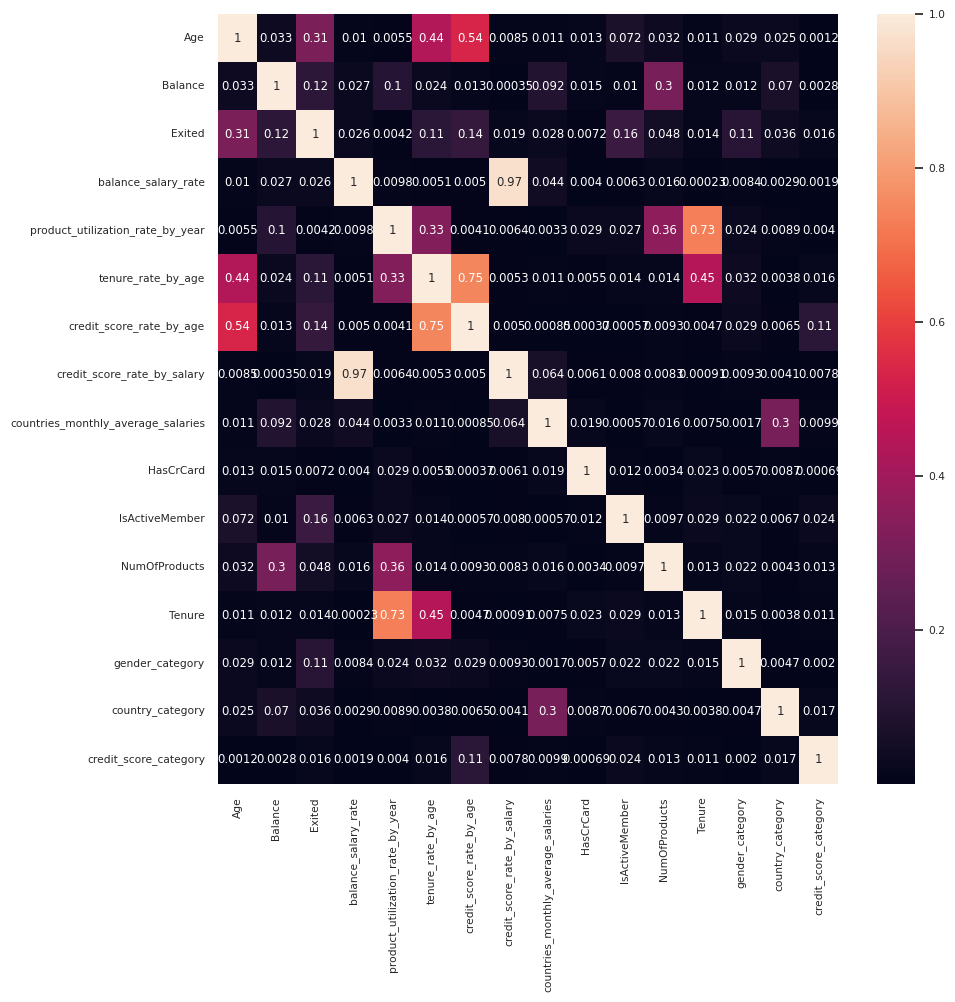

In [ ]:
correlation = df_encoded.corr().abs()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True)
plt.show()

List of correlation scores:

In [ ]:
corrs_results = df_encoded.corrwith(df_encoded["Exited"]).abs().nlargest(24)
corrs_results

Exited                               1.00
Age                                  0.31
IsActiveMember                       0.16
credit_score_rate_by_age             0.14
Balance                              0.12
tenure_rate_by_age                   0.11
gender_category                      0.11
NumOfProducts                        0.05
country_category                     0.04
countries_monthly_average_salaries   0.03
balance_salary_rate                  0.03
credit_score_rate_by_salary          0.02
credit_score_category                0.02
Tenure                               0.01
HasCrCard                            0.01
product_utilization_rate_by_year     0.00
dtype: float64

# 8.&nbsp;Apply Model

In [ ]:
# model_prepare test, train split 0.2
X_train, X_test, y_train, y_test = model_prepare(df_model=df_encoded)

In [ ]:
X_train

array([[-1.00395893,  1.18937499,  0.09596621, ...,  0.91517537,
         1.51308158,  0.99840512],
       [ 0.33045569,  0.68663432, -0.0278009 , ...,  0.91517537,
         0.30415827, -0.90351145],
       [-1.51719532,  0.60839642, -0.02175227, ...,  0.91517537,
         1.51308158,  0.99840512],
       ...,
       [-1.20925349,  0.91378639,  0.1455684 , ..., -1.09268675,
         1.51308158, -0.90351145],
       [ 0.43310297,  1.81748004, -0.01662468, ...,  0.91517537,
        -0.90476504,  0.04744684],
       [ 0.33045569,  0.8734367 , -0.02557798, ...,  0.91517537,
         0.30415827,  0.99840512]])

### 8.1. Logistic Regression Model

Have a look with Logistic Regression.

In [ ]:
logr_model = LogisticRegression()
logr_model.fit(X_train, y_train)
y_pred = logr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score of Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

           0     0.8502    0.9669    0.9048      1632
           1     0.6250    0.2446    0.3516       368

    accuracy                         0.8340      2000
   macro avg     0.7376    0.6057    0.6282      2000
weighted avg     0.8088    0.8340    0.8030      2000

Accuracy score of Logistic Regression:  0.834


### 8.2. Model Training

This is for all LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, and LGBMClassifier model objects:

In [ ]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('XGBoost', XGBClassifier()))
    models.append(('LightGBM', LGBMClassifier()))

    res_cols = ["model", "accuracy_score", "scale_method", "0_precision", "0_recall", "1_precision", "1_recall"]
    df_result = pd.DataFrame(columns=res_cols)
    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']

        idx_res_values = [name, score, "standardisasi", zero_report['precision'], zero_report['recall'], one_report['precision'], one_report['recall']]
        # df_result.at[index, res_cols] = idx_res_values
        df_result.loc[index, res_cols] = idx_res_values
        index += 1
    df_result = df_result.sort_values("accuracy_score", ascending=False).reset_index(drop=True)
    return df_result

In [ ]:
training_result = data_training(X_train, X_test, y_train, y_test)
training_result

[LightGBM] [Info] Number of positive: 1668, number of negative: 6329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 7997, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208578 -> initscore=-1.333517
[LightGBM] [Info] Start training from score -1.333517


,model,accuracy_score,scale_method,0_precision,0_recall,1_precision,1_recall
0,LightGBM,0.88,standardisasi,0.90,0.95,0.72,0.53
1,RF,0.87,standardisasi,0.89,0.96,0.73,0.46
2,GBM,0.87,standardisasi,0.89,0.96,0.71,0.48
3,XGBoost,0.86,standardisasi,0.89,0.95,0.67,0.49
4,KNN,0.85,standardisasi,0.88,0.94,0.61,0.44
5,LOGR,0.83,standardisasi,0.85,0.97,0.62,0.24
6,CART,0.79,standardisasi,0.88,0.85,0.43,0.49


# 9.&nbsp;Model Tuning

### 9.1. XGBoost Tuning

In [ ]:
xgb_model=XGBClassifier(
    learning_rate=0.23, max_delta_step=5,
    objective='reg:logistic', n_estimators=92,
    max_depth=5, eval_metric="logloss", gamma=3, base_score=0.5)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb, digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      1632
           1       0.75      0.49      0.60       368

    accuracy                           0.88      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.87      0.88      0.87      2000

Accuracy score of Tuned XGBoost Regression:  0.8765


### 9.2. Random Forest Tuning

In [ ]:
param_grid = {
    'max_depth': [3, 5, 6, 7, 8],
    'max_features': [2, 4, 6, 7, 8, 9],
    'n_estimators' : [50, 100],
    'min_samples_split': [3, 5, 6, 7]
}

randFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, refit = True, verbose = 0)
randFor_grid.fit(X_train, y_train)
best_model(randFor_grid)


# skipped, running too long

0.856821607254534
{'max_depth': 8, 'max_features': 9, 'min_samples_split': 6, 'n_estimators': 50}
RandomForestClassifier(max_depth=8, max_features=9, min_samples_split=6,
                       n_estimators=50)


Using the parameters and get final version accuracy score.

In [ ]:
rnd_model = RandomForestClassifier(
    max_depth=8,
    max_features=6,
    min_samples_split=6,
    n_estimators=50
)

rnd_model.fit(X_train, y_train)
y_pred_rf = rnd_model.predict(X_test)
print(classification_report(y_test, y_pred_rf, digits=2))
print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1632
           1       0.74      0.43      0.55       368

    accuracy                           0.87      2000
   macro avg       0.81      0.70      0.73      2000
weighted avg       0.86      0.87      0.85      2000

Accuracy score of tuned Random Forest model:  0.8675


### 9.3. LightGBM Tuning

In [ ]:
lgbm_model = LGBMClassifier(
    silent = 0, learning_rate = 0.09, max_delta_step = 2,
    n_estimators = 100, boosting_type = 'gbdt',
    max_depth = 10, eval_metric = "logloss",
    gamma = 3, base_score = 0.5
)

lgbm_model.fit(X_train, y_train)
y_pred_lgbm1 = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred_lgbm1, digits=2))
print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred_lgbm1))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1668, number of negative: 6329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] N

In [ ]:
lgbm_model = LGBMClassifier(
    silent=0, learning_rate=0.09, max_delta_step=2,
    n_estimators=100, boosting_type='gbdt',
    max_depth=10, eval_metric="logloss",
    gamma=3, base_score=0.5,
    is_unbalance=True,  # atau scale_pos_weight=imbalance_ratio
    objective='binary',  # atau metrik evaluasi lainnya
)

lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred_lgbm, digits=2))
print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred_lgbm))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1668, number of negative: 6329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] N

## 9.4 LogisticRegression Tuning

In [ ]:
# Model Logistic Regression
lr_model = LogisticRegression(solver='liblinear')
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='accuracy')
lr_grid.fit(X_train, y_train)

# Menggunakan model terbaik untuk prediksi
lr_best_model = lr_grid.best_estimator_
y_pred_lr = lr_best_model.predict(X_test)
print(classification_report(y_test, y_pred_lr, digits=2))
print("Accuracy score of tuned LogisticRegression model: ", accuracy_score(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1632
           1       0.62      0.24      0.35       368

    accuracy                           0.83      2000
   macro avg       0.74      0.61      0.63      2000
weighted avg       0.81      0.83      0.80      2000

Accuracy score of tuned LogisticRegression model:  0.834


## 9.5 KNN Tuning

In [ ]:
# Model K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='accuracy')
knn_grid.fit(X_train, y_train)

# Menggunakan model terbaik untuk prediksi
knn_best_model = knn_grid.best_estimator_
y_pred_knn = knn_best_model.predict(X_test)
print(classification_report(y_test, y_pred_knn, digits=2))
print("Accuracy score of tuned KNeighborsClassifier model: ", accuracy_score(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1632
           1       0.69      0.40      0.51       368

    accuracy                           0.86      2000
   macro avg       0.78      0.68      0.71      2000
weighted avg       0.84      0.86      0.84      2000

Accuracy score of tuned KNeighborsClassifier model:  0.857


## 9.6 GBoost Tuning

In [ ]:
# Model Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}
gb_grid = GridSearchCV(gb_model, gb_param_grid, cv=5, scoring='accuracy')
gb_grid.fit(X_train, y_train)

# Menggunakan model terbaik untuk prediksi
gb_best_model = gb_grid.best_estimator_
y_pred_gb = gb_best_model.predict(X_test)
print(classification_report(y_test, y_pred_gb, digits=2))
print("Accuracy score of tuned GradientBoostingClassifier model: ", accuracy_score(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1632
           1       0.71      0.49      0.58       368

    accuracy                           0.87      2000
   macro avg       0.80      0.72      0.75      2000
weighted avg       0.86      0.87      0.86      2000

Accuracy score of tuned GradientBoostingClassifier model:  0.87


## 9.7 DecisionTree Tuning

In [ ]:
# Model Decision Tree
dt_model = DecisionTreeClassifier()
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)

# Menggunakan model terbaik untuk prediksi
dt_best_model = dt_grid.best_estimator_
y_pred_dt = dt_best_model.predict(X_test)
print(classification_report(y_test, y_pred_dt, digits=2))
print("Accuracy score of tuned DecisionTreeClassifier model: ", accuracy_score(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1632
           1       0.58      0.45      0.50       368

    accuracy                           0.84      2000
   macro avg       0.73      0.69      0.70      2000
weighted avg       0.83      0.84      0.83      2000

Accuracy score of tuned DecisionTreeClassifier model:  0.8385


# 10.&nbsp;Confusion Matrix

##10.1 XGBoost Confusion Matrix

Confusion matrix, without normalization


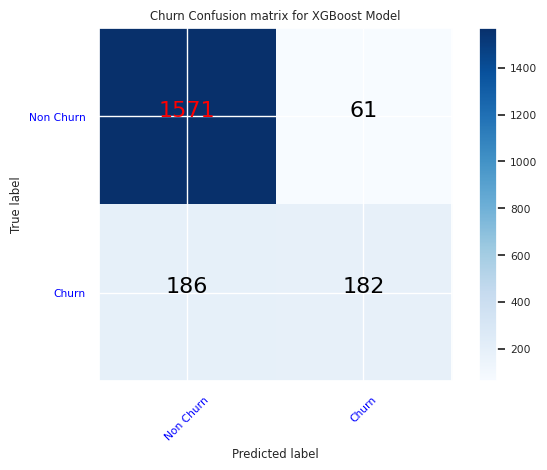

In [ ]:
cfm = confusion_matrix(y_test, y_pred=y_pred_xgb)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix for XGBoost Model'
)

tn, fp, fn, tp = cfm.ravel()

#print("True Negatives: ",tn)
#print("False Positives: ",fp)
#print("False Negatives: ",fn)
#print("True Positives: ",tp)

##10.2 Random Forest Confusion Matrix

Confusion matrix, without normalization


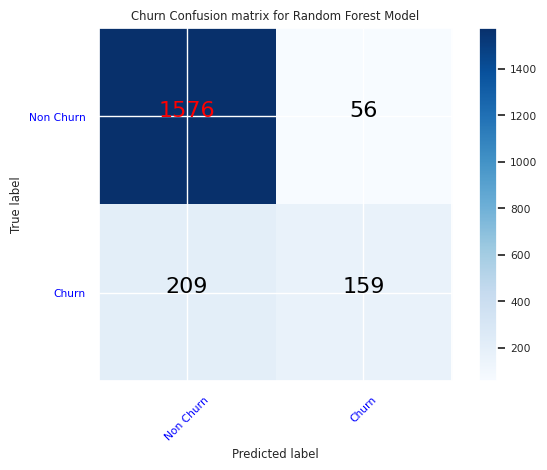

In [ ]:
cfm = confusion_matrix(y_test, y_pred=y_pred_rf)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix for Random Forest Model'
)

tn, fp, fn, tp = cfm.ravel()

#print("True Negatives: ",tn)
#print("False Positives: ",fp)
#print("False Negatives: ",fn)
#print("True Positives: ",tp)

##10.3 LGBM Confusion Matrix

Confusion matrix, without normalization


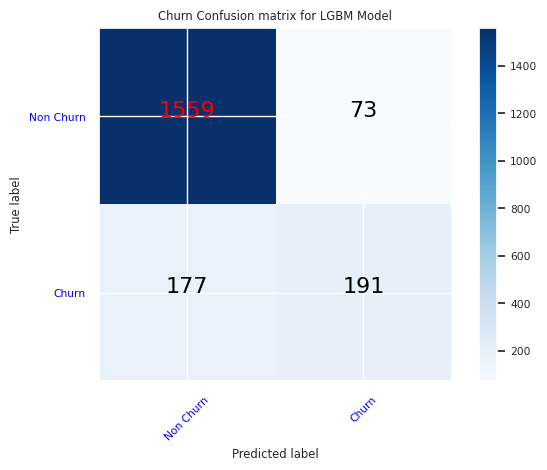

In [ ]:
cfm = confusion_matrix(y_test, y_pred=y_pred_lgbm1)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix for LGBM Model'
)

tn, fp, fn, tp = cfm.ravel()

#print("True Negatives: ",tn)
#print("False Positives: ",fp)
#print("False Negatives: ",fn)
#print("True Positives: ",tp)

- dia dapat memprediksi customer churned sebanyak 191 dan Non Churn 1559
- Memprediksi customer churned menjadi Non churned sebanyak 177 (Memberikan kerugian bagi perusahaan karena perusahaan berpotensi kehilangan 177 customer)
- Memprediksikan customer Non Churned menjadi churned sebanyak 73 (Memberikan warning pada perusahaan untuk keep 73 customer, hal ini mungkin bisa memberikan kerugian bagi perusahaan karena harus mengeluarkan strategi atau dana untuk mempertahankan 73 customer yang sebenarnya mereka tidak termasuk customer Churned)

Confusion matrix, without normalization


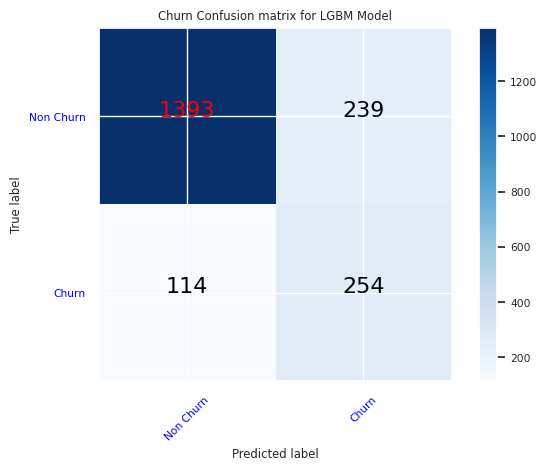

In [ ]:
cfm = confusion_matrix(y_test, y_pred=y_pred_lgbm)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix for LGBM Model'
)

tn, fp, fn, tp = cfm.ravel()

#print("True Negatives: ",tn)
#print("False Positives: ",fp)
#print("False Negatives: ",fn)
#print("True Positives: ",tp)

LGBM memberi hasil terbaik dari model yang lain :
- dia dapat memprediksi customer churned sebanyak 254 dan Non Churn 1393
- Memprediksi customer churned menjadi Non churned sebanyak 114 (Memberikan kerugian bagi perusahaan karena perusahaan berpotensi kehilangan 114 customer)
- Memprediksikan customer Non Churned menjadi churned sebanyak 239 (Memberikan warning pada perusahaan untuk keep 239 customer, hal ini mungkin bisa memberikan kerugian bagi perusahaan karena harus mengeluarkan strategi atau dana untuk mempertahankan 239 customer yang sebenarnya mereka tidak termasuk customer Churned)

##10.4 LogisticREgression Confusion Matrix

Confusion matrix, without normalization


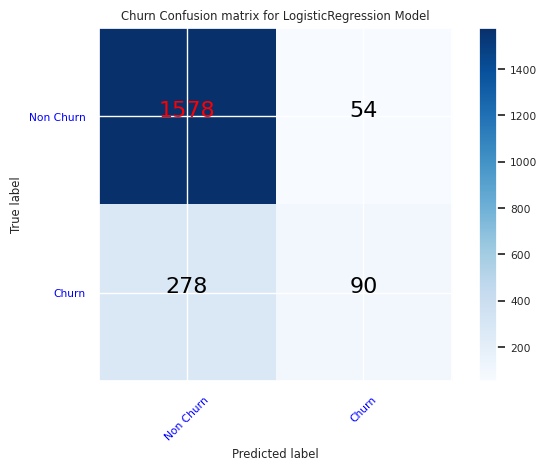

In [ ]:
cfm = confusion_matrix(y_test, y_pred=y_pred_lr)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix for LogisticRegression Model'
)

tn, fp, fn, tp = cfm.ravel()

#print("True Negatives: ",tn)
#print("False Positives: ",fp)
#print("False Negatives: ",fn)
#print("True Positives: ",tp)

##10.5 KNN Confusion Matrix

Confusion matrix, without normalization


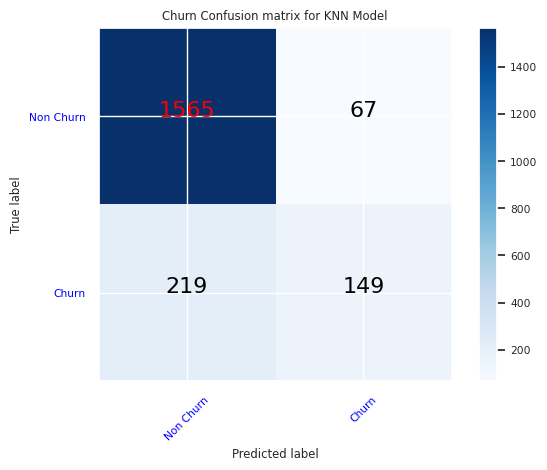

In [ ]:
cfm = confusion_matrix(y_test, y_pred=y_pred_knn)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix for KNN Model'
)

tn, fp, fn, tp = cfm.ravel()

#print("True Negatives: ",tn)
#print("False Positives: ",fp)
#print("False Negatives: ",fn)
#print("True Positives: ",tp)

##10.6 GradienBoost Confusion Matrix

Confusion matrix, without normalization


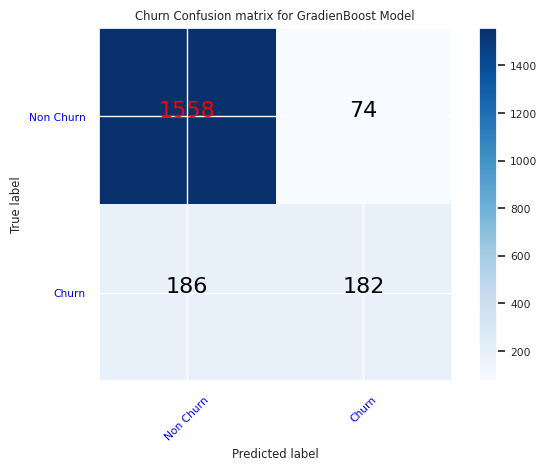

In [ ]:
cfm = confusion_matrix(y_test, y_pred=y_pred_gb)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix for GradienBoost Model'
)

tn, fp, fn, tp = cfm.ravel()

#print("True Negatives: ",tn)
#print("False Positives: ",fp)
#print("False Negatives: ",fn)
#print("True Positives: ",tp)

##10.7 Decision Tree Confusion Matrix

Confusion matrix, without normalization


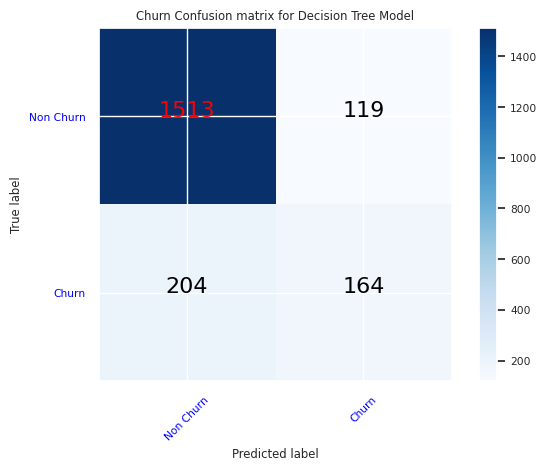

In [ ]:
cfm = confusion_matrix(y_test, y_pred=y_pred_dt)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix for Decision Tree Model'
)

tn, fp, fn, tp = cfm.ravel()

#print("True Negatives: ",tn)
#print("False Positives: ",fp)
#print("False Negatives: ",fn)
#print("True Positives: ",tp)

# 11.&nbsp;ROC Curve

In [ ]:
! pip install scikit-plot

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


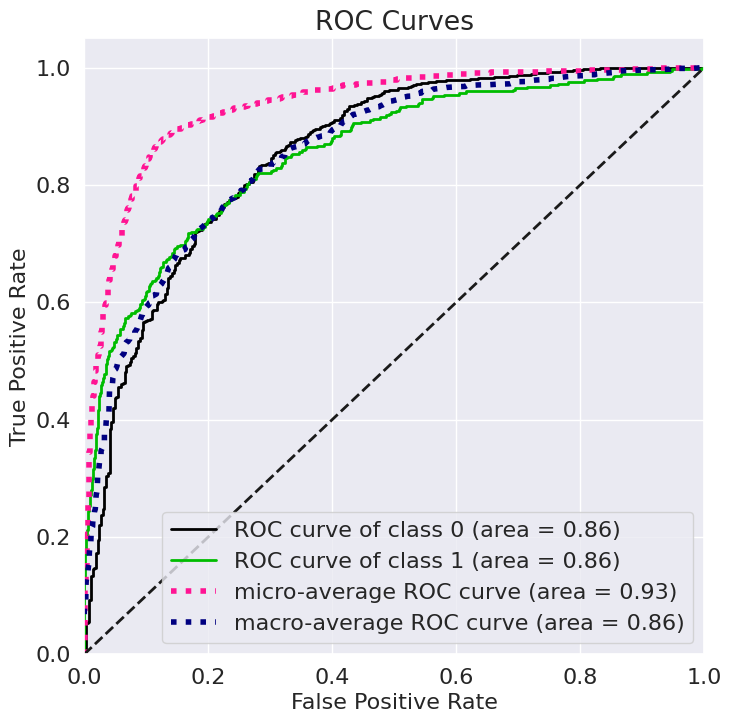

In [ ]:
import scikitplot as skplt
y_pred_proba = lgbm_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba, figsize=(8,8))

plt.show()

## 11.1 ROC Curve compare

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
# Memprediksi probabilitas kelas positif
rnd_probs = rnd_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
lgbm_probs = lgbm_model.predict_proba(X_test)[:, 1]
lr_probs = lr_best_model.predict_proba(X_test)[:, 1]
knn_probs = knn_best_model.predict_proba(X_test)[:, 1]
gb_probs = gb_best_model.predict_proba(X_test)[:, 1]
dt_probs = dt_best_model.predict_proba(X_test)[:, 1]

# Menghitung ROC curve
rnd_fpr, rnd_tpr, _ = roc_curve(y_test, rnd_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)

# Menghitung AUC (Area Under the Curve)
rnd_auc = auc(rnd_fpr, rnd_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)
lgbm_auc = auc(lgbm_fpr, lgbm_tpr)
lr_auc = auc(lr_fpr, lr_tpr)
knn_auc = auc(knn_fpr, knn_tpr)
gb_auc = auc(gb_fpr, gb_tpr)
dt_auc = auc(dt_fpr, dt_tpr)


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


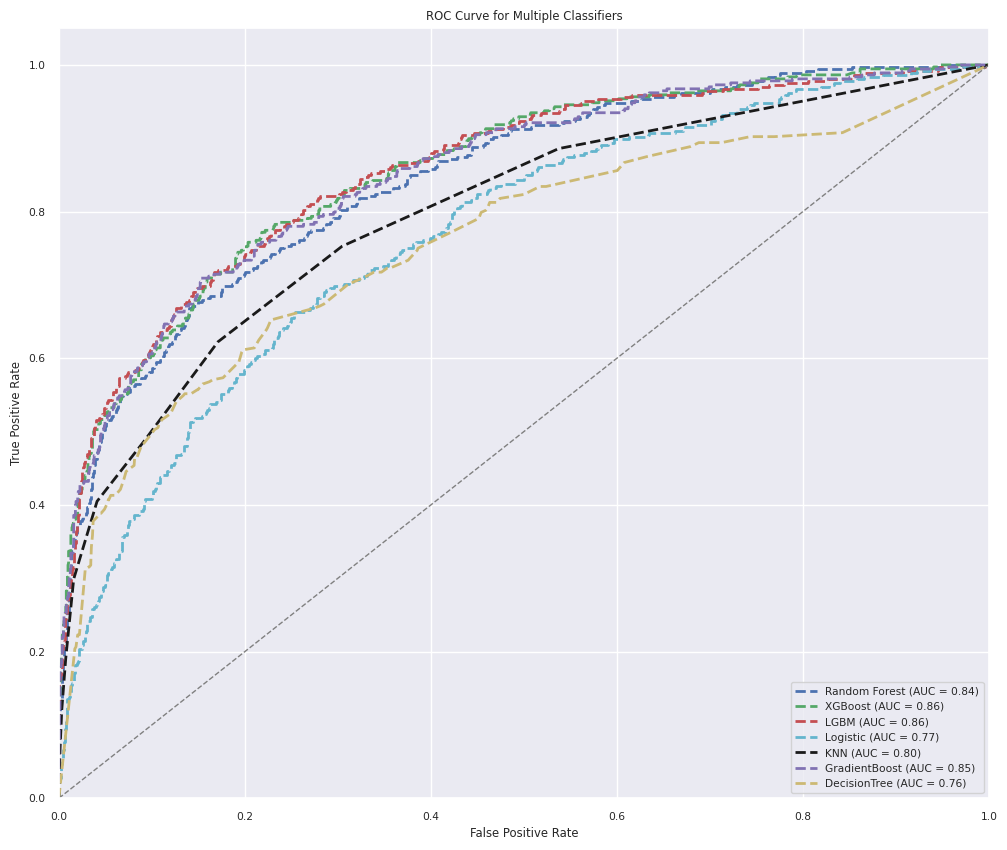

In [ ]:
# Menampilkan ROC Curve dalam satu plot
plt.figure(figsize=(12, 10))
plt.plot(rnd_fpr, rnd_tpr, color='b', lw=2, label=f'Random Forest (AUC = {rnd_auc:.2f})', linestyle='--')
plt.plot(xgb_fpr, xgb_tpr, color='g', lw=2, label=f'XGBoost (AUC = {xgb_auc:.2f})', linestyle='--')
plt.plot(lgbm_fpr, lgbm_tpr, color='r', lw=2, label=f'LGBM (AUC = {lgbm_auc:.2f})', linestyle='--')
plt.plot(lr_fpr, lr_tpr, color='c', lw=2, label=f'Logistic (AUC = {lr_auc:.2f})', linestyle='--')
plt.plot(knn_fpr, knn_tpr, color='k', lw=2, label=f'KNN (AUC = {knn_auc:.2f})', linestyle='--')
plt.plot(gb_fpr, gb_tpr, color='m', lw=2, label=f'GradientBoost (AUC = {gb_auc:.2f})', linestyle='--')
plt.plot(dt_fpr, dt_tpr, color='y', lw=2, label=f'DecisionTree (AUC = {dt_auc:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiple Classifiers')
plt.legend(loc='lower right')
plt.show()

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


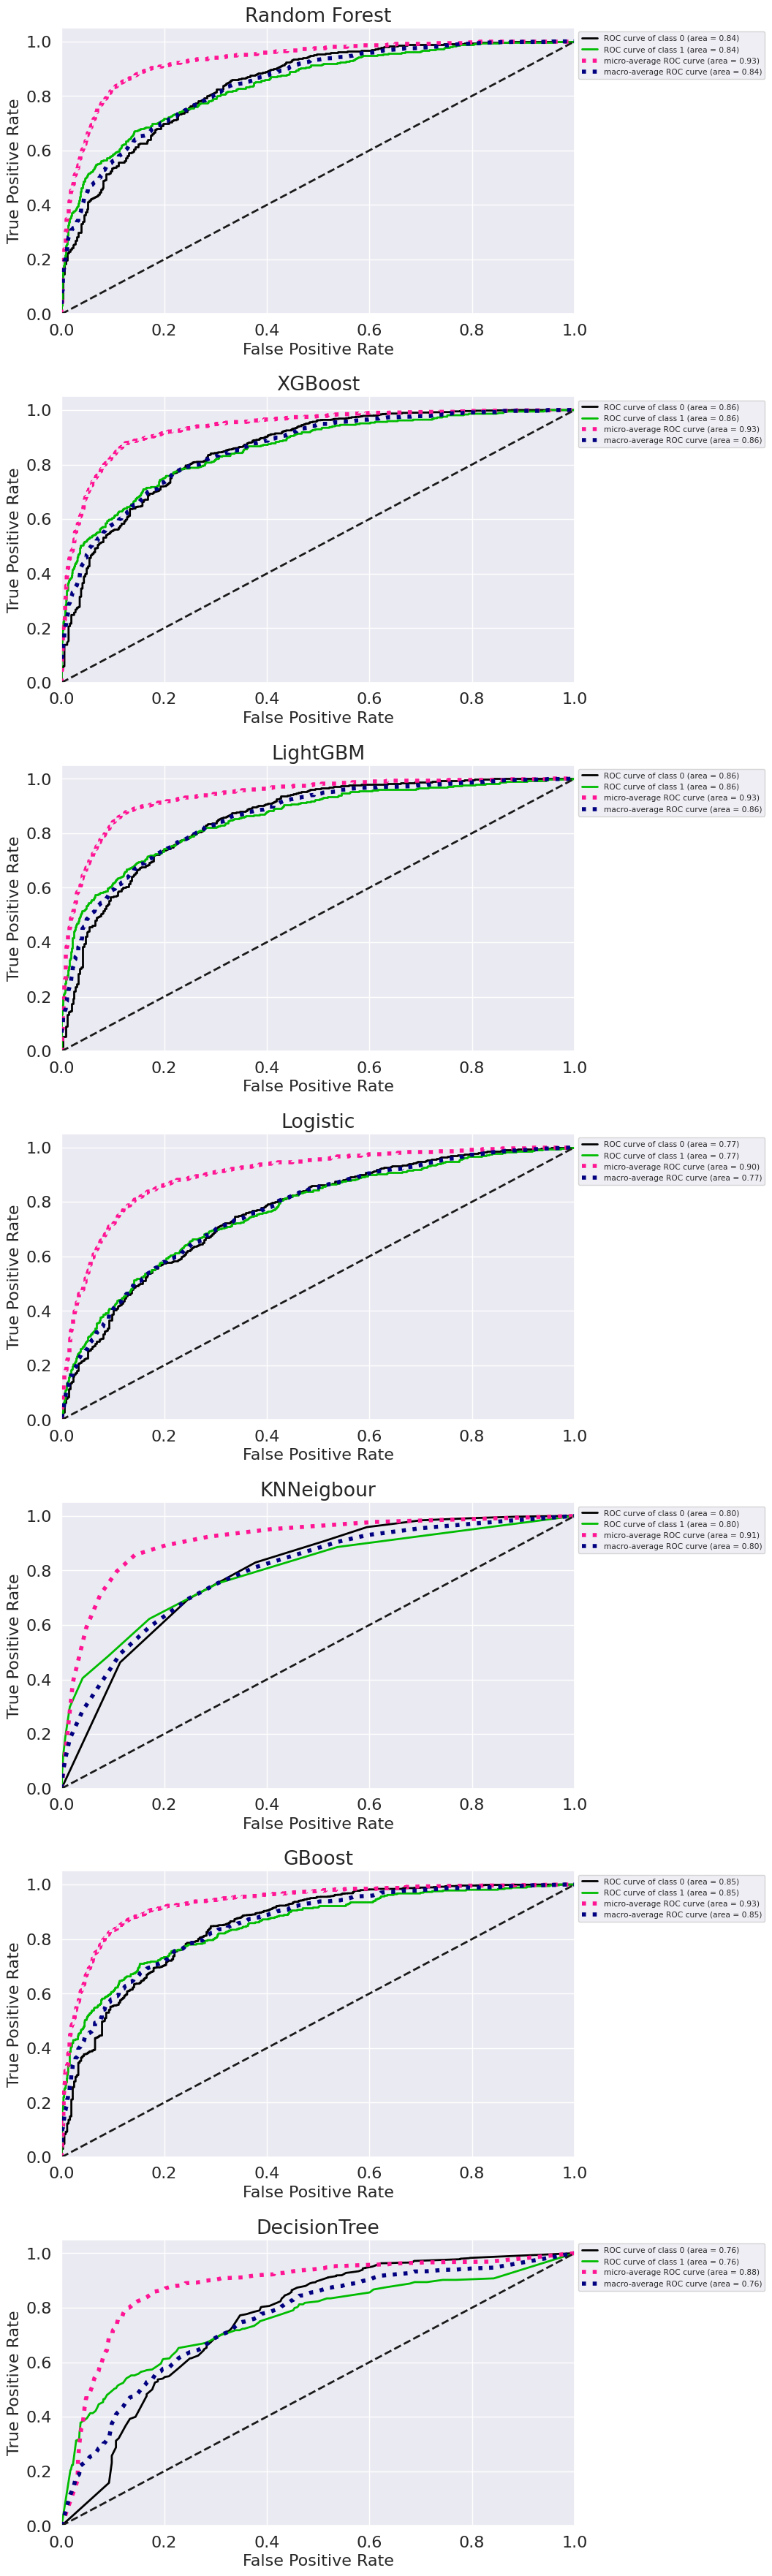

In [ ]:
# Memprediksi probabilitas kelas positif
rnd_probs = rnd_model.predict_proba(X_test)
xgb_probs = xgb_model.predict_proba(X_test)
lgbm_probs = lgbm_model.predict_proba(X_test)
lr_probs = lr_best_model.predict_proba(X_test)
knn_probs = knn_best_model.predict_proba(X_test)
gb_probs = gb_best_model.predict_proba(X_test)
dt_probs = dt_best_model.predict_proba(X_test)

# Menggunakan scikit-plot untuk membuat ROC Curve
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 35))

skplt.metrics.plot_roc(y_test, rnd_probs, title='Random Forest', ax=axes[0])
skplt.metrics.plot_roc(y_test, xgb_probs, title='XGBoost', ax=axes[1])
skplt.metrics.plot_roc(y_test, lgbm_probs, title='LightGBM', ax=axes[2])
skplt.metrics.plot_roc(y_test, lr_probs, title='Logistic', ax=axes[3])
skplt.metrics.plot_roc(y_test, knn_probs, title='KNNeigbour', ax=axes[4])
skplt.metrics.plot_roc(y_test, gb_probs, title='GBoost', ax=axes[5])
skplt.metrics.plot_roc(y_test, dt_probs, title='DecisionTree', ax=axes[6])

# Menempatkan legend ke luar grafik (di bawah gambar keseluruhan)
plt.tight_layout()
fig.subplots_adjust(top=1, right=1)
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[2].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[3].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[4].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[5].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[6].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

# 12.&nbsp;Feature Importance

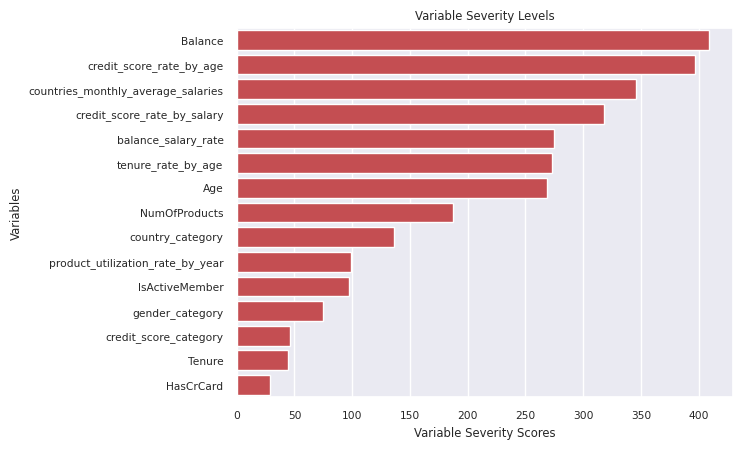

In [ ]:
feature_index = df_encoded.loc[:, df_encoded.columns != dependent_variable_name]

feature_importance = pd.Series(
    lgbm_model.feature_importances_,
    index=feature_index.columns
)
feature_importance = feature_importance.sort_values(ascending=False)

sns.barplot(
    x=feature_importance,
    y=feature_importance.index,
    color='r',
    saturation=1
)

plt.xlabel('Variable Severity Scores')
plt.ylabel('Variables')
plt.title('Variable Severity Levels')
plt.show()

# 13.&nbsp;Conclusion



Setelah saya melakukan tunning untuk beberaapa model yg digunakan,
urutan Best model dari analisa saya mengunakan ROC Curve for multiple Classifiers :
1. LGBM
2. XGBoost
3. GradientBoost
4. Random Forest
5. KNN
6. LogisticRegressor
7. DecisionTree

Meskipun terdapat perbedaan yg **tidak terlalu signifikan** antara LGBM dengan XGBoost